In [1]:
import pandas as pd
import os
import numpy as np
from PIL import Image
from skimage.feature import hog
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = 'elpv-dataset-master'
data = pd.read_csv(os.path.join(data_dir, 'labels.csv'), sep=' ', header=None)

FileNotFoundError: [Errno 2] No such file or directory: 'elpv-dataset\\labels.csv'

In [ ]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,images/cell0001.png,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mono
1,images/cell0002.png,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mono
2,images/cell0003.png,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mono
3,images/cell0004.png,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mono
4,images/cell0005.png,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mono


In [ ]:
data[2].unique() 

array([1.        , 0.        , 0.33333333, 0.66666667])

In [ ]:
all_data = pd.DataFrame()

In [ ]:
# 0 certainly defective, 1 likely defective, 2 possibly defective, 3 fully functional
prob2cat = {
    1.0: 0,
    2/3: 1,
    1/3: 2,
    0.0: 3
}
image_paths = [os.path.join(data_dir, path) for path in data[0]]
labels = [prob2cat[prob] for prob in data[2]]

In [ ]:
all_data['image_path'] = image_paths
all_data['label'] = labels

In [ ]:
all_data.head()

,image_path,label
0,elpv-dataset/images/cell0001.png,0
1,elpv-dataset/images/cell0002.png,0
2,elpv-dataset/images/cell0003.png,0
3,elpv-dataset/images/cell0004.png,3
4,elpv-dataset/images/cell0005.png,0


In [ ]:
X = all_data.copy()
y = X.pop('label')

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.25, random_state=0)

In [ ]:
train_X = train_X.to_numpy().reshape(-1)
train_y = train_y.to_numpy()

In [ ]:
valid_X = valid_X.to_numpy().reshape(-1)
valid_y = valid_y.to_numpy()

In [ ]:
def generate_features(image_paths, hog_):
    images = []
    for path in tqdm(image_paths, desc='Generating Features'):
        if hog_:
            image = np.array(Image.open(path))
            image = hog(image, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True)[0]
        else:
            image = np.array(Image.open(path)).reshape(-1)
        images.append(image)
    images = normalize(np.array(images))
    return images
        

In [ ]:
def metric(preds, truth):
    acc = accuracy_score(preds, truth)
    f1 = f1_score(preds, truth, average='macro')
    r = recall_score(preds, truth, average='macro')
    p = precision_score(preds, truth, average='macro')
    cm = confusion_matrix(preds, truth)
    print('Accuracy: ',  acc)
    print('F1 Score: ', f1)
    print('Recall Score: ', r)
    print('Precision Score: ', p)
    print('Confusion Matrix: ')
    sns.heatmap(cm)
    

In [ ]:
train_X = generate_features(train_X, True)
valid_X = generate_features(valid_X, True)

Generating Features: 100%|█████████████████████| 656/656 [01:19<00:00,  8.28it/s]


In [ ]:
model = SVC(random_state=0)
model.fit(train_X, train_y)
preds = model.predict(valid_X)

Accuracy:  0.6966463414634146
F1 Score:  0.36388918131733167
Recall Score:  0.3547878055331722
Precision Score:  0.3853219696969697
Confusion Matrix: 


/Users/lingeng/miniforge3/envs/rubbish/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


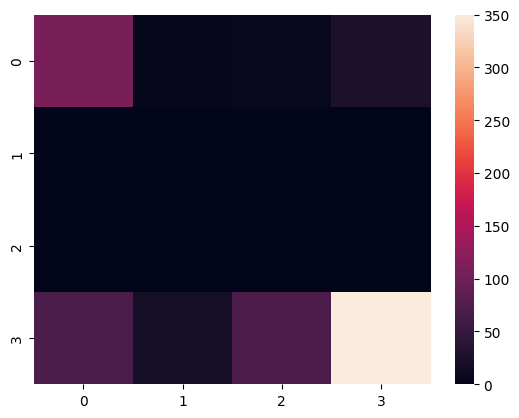

In [ ]:
metric(preds, valid_y)